# Pneumonia detection in chest X-Ray images

## Introduction



The dataset consists of chest X-Rays given for patients with and without pneumonia. It is hard to detect disease by not educated person. Besides, it requires some time even for professional doctor to detect pneumonia. Thus, an automated approach would help with fast pneumonia diagnostic.

There are two forms of pneumonia which are given in the dataset: bacterial and viral. The first task to solve is to find if patient has pneumonia at all (Binary Classification). Then the second task is to try to determine an actual form of the pneumonia if any (Multi-Class Classification.

## Dataset overview

In [80]:
import os
import random
import numpy as np
import tensorflow as tf
from keras import backend as K
import cv2
import glob
import pandas as pd
from matplotlib import pyplot as plt
from math import ceil, floor
from tqdm import tqdm, tqdm_notebook
from skimage import morphology
from keras.utils.data_utils import get_file
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from imblearn.under_sampling import RandomUnderSampler
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import label_binarize

from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential, Input, Model
from keras.layers import Conv2D, MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, ZeroPadding2D, Dense, Dropout, \
    Flatten, Input, LSTM, TimeDistributed
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import recall_score, auc, roc_auc_score, f1_score, roc_curve, classification_report, confusion_matrix

We define global constants where the needed directories paths are stored. Then we create the directories if some are not exist

In [2]:
base_data_dir = '../data/chest_xray/'

data_dir = base_data_dir + 'prepared/'
normal_dir = data_dir + 'normal/'
pneumonia_dir = data_dir + 'pneumonia/'
bacteria_dir = pneumonia_dir + 'bacteria/'
virus_dir = pneumonia_dir + 'virus/'
models_dir = './models/'
models_lungs_dir = models_dir + 'lung/'
models_binary_dir = models_dir + 'binary/'
models_categorical_dir = models_dir + 'categorical/'

for directory in [normal_dir, bacteria_dir, virus_dir, models_lungs_dir,
                  models_binary_dir, models_categorical_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

lung_segmentation_model_path = models_lungs_dir + 'lung_segmentation.hdf5'

The initial dataset already have some separation of the test, train and validation sets. We gather images from all these directories because we will use our own split.

In [3]:
normal_patterns = [
    base_data_dir + 'train/NORMAL/*.jpeg',
    base_data_dir + 'test/NORMAL/*.jpeg',
    base_data_dir + 'val/NORMAL/*.jpeg'
]

bacteria_patterns = [
    base_data_dir + 'train/PNEUMONIA/*bacteria*.jpeg',
    base_data_dir + 'test/PNEUMONIA/*bacteria*.jpeg',
    base_data_dir + 'val/PNEUMONIA/*bacteria*.jpeg'
]

virus_patterns = [
    base_data_dir + 'train/PNEUMONIA/*virus*.jpeg',
    base_data_dir + 'test/PNEUMONIA/*virus*.jpeg',
    base_data_dir + 'val/PNEUMONIA/*virus*.jpeg'
]

raw_normal = [item for sublist in [glob.glob(path) for path in normal_patterns] for item in sublist]
raw_bacteria = [item for sublist in [glob.glob(path) for path in bacteria_patterns] for item in sublist]
raw_virus = [item for sublist in [glob.glob(path) for path in virus_patterns] for item in sublist]

Plot a few examples of the normal images and images with bacterial and viral pneumonias 

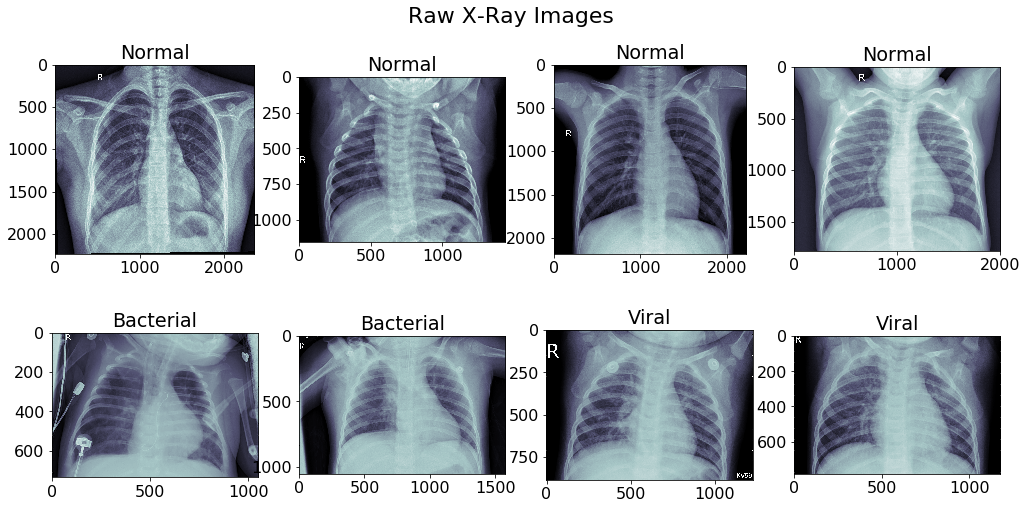

In [230]:
preview_n = 8
preview_n_i = [0, 10, 20, 30]
preview_b_i = [0, 10]
preview_v_i = [0, 10]

preview_paths = np.array(raw_normal)[preview_n_i].tolist() + np.array(raw_bacteria)[preview_b_i].tolist() + np.array(raw_virus)[preview_v_i].tolist()

fig = plt.figure(figsize = (17, 8))
plt.suptitle("Raw X-Ray Images", size = 22)
for i in range(2):
    for k in range(preview_n // 2):
        index = i * preview_n // 2 + k
        img = cv2.imread(preview_paths[index], 0)
        ax = plt.subplot(2, preview_n // 2, index + 1)
        im = plt.imshow(img, cmap='bone')
        if index < preview_n // 2:
            plt.title('Normal')
        elif index < preview_n // 2 + preview_n // 4:
            plt.title('Bacterial')
        else:
            plt.title('Viral')
            
plt.subplots_adjust(hspace = 0.3)
plt.show()

As far as we can see that dataset consists of images with various image sizes, some images are not symmetric and contain a lot of useless information around except for lungs.

We need to preprocess images first in order to get rid of the useless information and to normalize images. The lung segmentation algorithm available at https://github.com/imlab-uiip/lung-segmentation-2d is used for this purpose. This is already trained UNet neural network which is for the specific purpose of lung segmentation.

In [4]:
get_file('lung_segmentation.hdf5',
         'https://raw.githubusercontent.com/imlab-uiip/lung-segmentation-2d/master/trained_model.hdf5',
         cache_dir = models_dir, cache_subdir = 'lung')

UNet = load_model(lung_segmentation_model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/Users/zhuvikin/anaconda3/envs/AIU_ML/lib/python3.7/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


However, the used lung segmentation model does not recognize the correct lungs areas all the time and we use some lungs mask post-processing in order to make sure we do not crop usefull information in the images

In [5]:
def adjust_gamma(image, gamma = 1.0):
    invGamma = 1.0 / gamma
    table = np.array([
        ((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))


def adjust_contrast(image, contrast = 0):
    buf = image.copy()
    if contrast != 0:
        f = 131 * (contrast + 127) / (127 * (131 - contrast))
        alpha_c = f
        gamma_c = 127 * (1 - f)
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)
    return buf


def normalize_image(original, target_width = 256):
    im_shape = (256, 256)
    original_width = original.shape[1]
    original_height = original.shape[0]

    width_coeff = 256 / original_width
    height_coeff = 256 / original_height

    img = cv2.resize(original, im_shape, interpolation = cv2.INTER_AREA)
    img = cv2.equalizeHist(img)
    img = adjust_gamma(img, 0.75)
    img = img * 1.2
    img = np.clip(img, 0, 255)

    img2 = img.astype(float)
    img2 -= img2.mean()
    img2 /= img2.std()

    img2 = np.expand_dims(img2, -1)
    inp_shape = img2.shape
    pred = UNet.predict([[img2]])[..., 0].reshape(inp_shape[:2])
    pr = pred > 0.5
    pr = remove_small_regions(pr, 0.01 * np.prod(im_shape))
    pr = pr.astype(int)

    non_empty_columns = np.where(pr.max(axis = 0) > 0)[0]
    non_empty_rows = np.where(pr.max(axis = 1) > 0)[0]
    left = min(non_empty_columns) if len(non_empty_columns) > 0 else 0
    right = max(non_empty_columns) if len(non_empty_columns) > 0 else 256
    top = min(non_empty_rows) if len(non_empty_rows) > 0 else 0
    bottom = max(non_empty_rows) if len(non_empty_rows) > 0 else 256

    if right < 256 / 1.9:
        right = 256 - left

    if left > 256 / 2.1:
        left = 256 - right

    l = floor(left / width_coeff)
    t = floor(top / height_coeff)
    w = floor((right - left) / width_coeff)
    h = floor((bottom - top) / height_coeff)

    cropped = original[t:t + h, l:l + w]
    resized = cv2.resize(cropped, (target_width, target_width), interpolation = cv2.INTER_AREA)
    equalized = cv2.equalizeHist(resized)
    return equalized


def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

Normalize dataset and save in the `prepeared` folder

In [6]:
image_width = 256

i = 0
for path in tqdm_notebook(raw_normal):
    output_path = normal_dir + '{0:04d}.jpeg'.format(i)
    if not os.path.exists(output_path):
        img = cv2.imread(path, 0)
        normalized = normalize_image(img, image_width)
        cv2.imwrite(output_path, normalized)
    i += 1

i = 0
for path in tqdm_notebook(raw_bacteria + raw_virus):
    if 'bacteria' in path:
        output_path = bacteria_dir + '{0:04d}.jpeg'.format(i)
    else:
        output_path = virus_dir + '{0:04d}.jpeg'.format(i)
    if not os.path.exists(output_path):
        img = cv2.imread(path, 0)
        normalized = normalize_image(img, image_width)
        cv2.imwrite(output_path, normalized)
    i += 1

In [7]:
normal_df = pd.DataFrame(
    {'path': glob.glob(normal_dir + '*.jpeg'), 'normal': 1, 'bacteria': 0, 'virus': 0, 'target': 'Normal'})
bacteria_df = pd.DataFrame(
    {'path': glob.glob(bacteria_dir + '*.jpeg'), 'normal': 0, 'bacteria': 1, 'virus': 0, 'target': 'Pneumonia'})
virus_df = pd.DataFrame(
    {'path': glob.glob(virus_dir + '*.jpeg'), 'normal': 0, 'bacteria': 0, 'virus': 1, 'target': 'Pneumonia'})

# normal_df = pd.DataFrame(
#     {'path': raw_normal, 'normal': 1, 'bacteria': 0, 'virus': 0, 'target': 'Normal'})
# bacteria_df = pd.DataFrame(
#     {'path': raw_bacteria, 'normal': 0, 'bacteria': 1, 'virus': 0, 'target': 'Pneumonia'})
# virus_df = pd.DataFrame(
#     {'path': raw_virus, 'normal': 0, 'bacteria': 0, 'virus': 1, 'target': 'Pneumonia'})

Compare the previously shown raw images with the normalized versions

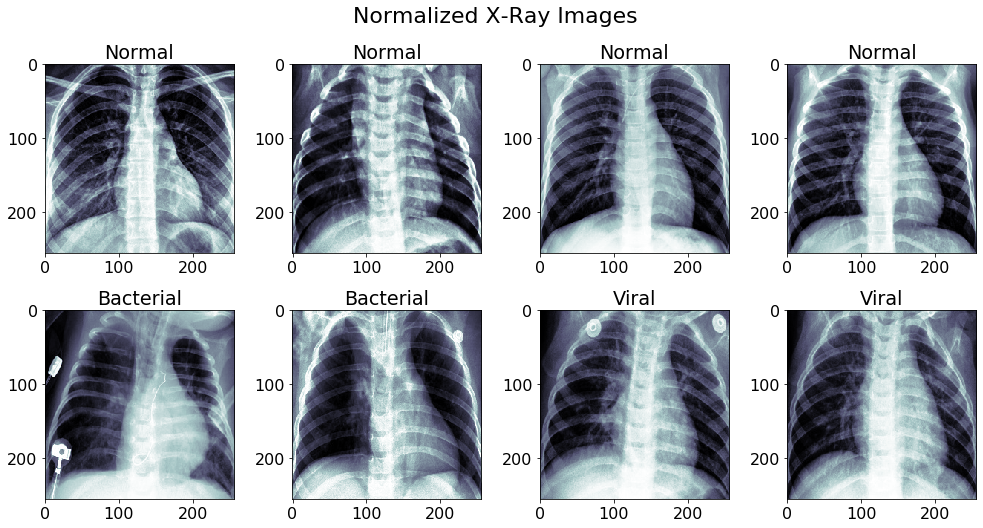

In [231]:
processed_previews = np.array(list(normal_df.sort_values('path').path))[preview_n_i].tolist() + np.array(list(bacteria_df.sort_values('path').path))[preview_b_i].tolist() + np.array(list(virus_df.sort_values('path').path))[preview_v_i].tolist()
fig = plt.figure(figsize = (17, 8))
plt.suptitle("Normalized X-Ray Images", size = 22)
for i in range(2):
    for k in range(preview_n // 2):
        index = i * preview_n // 2 + k
        img = cv2.imread(processed_previews[index], 0)
        ax = plt.subplot(2, preview_n // 2, index + 1)
        im = plt.imshow(img, cmap='bone')
        if index < preview_n // 2:
            plt.title('Normal')
        elif index < preview_n // 2 + preview_n // 4:
            plt.title('Bacterial')
        else:
            plt.title('Viral')

plt.subplots_adjust(hspace = 0.3)
plt.show()

In [ ]:
dataset = pd.concat([normal_df, bacteria_df, virus_df])
dataset = dataset.sort_values('path')
dataset = dataset.sample(frac = 1, random_state = 0).reset_index(drop = True)

In [8]:
pd.set_option('max_colwidth', 100)
dataset.head(10)

,path,normal,bacteria,virus,target
0,../data/chest_xray/prepared/pneumonia/bacteria/2448.jpeg,0,1,0,Pneumonia
1,../data/chest_xray/prepared/pneumonia/bacteria/0207.jpeg,0,1,0,Pneumonia
2,../data/chest_xray/prepared/normal/0608.jpeg,1,0,0,Normal
3,../data/chest_xray/prepared/pneumonia/virus/4160.jpeg,0,0,1,Pneumonia
4,../data/chest_xray/prepared/pneumonia/virus/4161.jpeg,0,0,1,Pneumonia
5,../data/chest_xray/prepared/pneumonia/bacteria/1984.jpeg,0,1,0,Pneumonia
6,../data/chest_xray/prepared/normal/1045.jpeg,1,0,0,Normal
7,../data/chest_xray/prepared/pneumonia/virus/3815.jpeg,0,0,1,Pneumonia
8,../data/chest_xray/prepared/normal/0642.jpeg,1,0,0,Normal
9,../data/chest_xray/prepared/pneumonia/bacteria/1023.jpeg,0,1,0,Pneumonia


Let us check if there are common features of normal images and images with pneumonia. We perform Karhunen Loeve Decomposition for the first `1500` images for both classes and plot first few principal component images

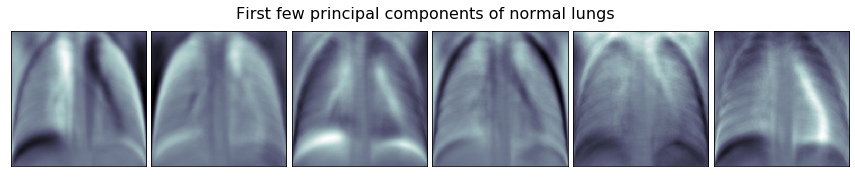

One can even clearly observe bronchus system in few most significant components of normal lungs


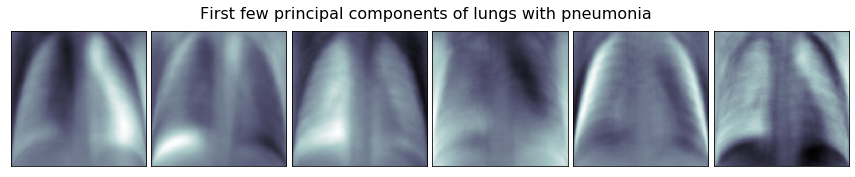

Pleural effusions and airspace consolidation in the different parts of the lungs with pneumonia make few first principal components a bit blurred


In [232]:
number_of_images = 1500
n_row, n_col = 1, 6
n_components = n_row * n_col

pca = PCA(n_components = n_components, svd_solver = 'randomized', whiten = True)

plt.rcParams.update({'font.size': 16})

def plot_gallery(title, images, n_col = n_col, n_row = n_row, cmap = plt.cm.gray):
    plt.figure(figsize = (2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size = 16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(256, 256), cmap='bone',
                   interpolation = 'nearest',
                   vmin = -vmax, vmax = vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.02, -0.1, 0.99, 0.93, 0.04, 0.)


few_normal_images = np.array([cv2.imread(path, 0).flatten() for path in normal_df.head(number_of_images).path])
pca.fit(few_normal_images)
plot_gallery('First few principal components of normal lungs', pca.components_[:n_components])
plt.show()

print('One can even clearly observe bronchus system in few most significant components of normal lungs')

pneumonia_df = pd.concat([bacteria_df, virus_df]).sample(frac = 1, random_state = 0).reset_index(drop = True)
few_pneumonia_images = np.array([cv2.imread(path, 0).flatten() for path in pneumonia_df.head(number_of_images).path])
pca.fit(few_pneumonia_images)
plot_gallery('First few principal components of lungs with pneumonia', pca.components_[:n_components])
plt.show()

print(
    'Pleural effusions and airspace consolidation in the different parts of the lungs with pneumonia make few first principal components a bit blurred')

Check the balance of the classes in the dataset

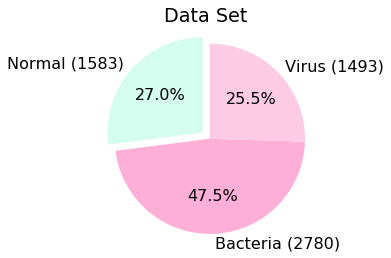

In [136]:
colors = ['#D4FCEF', '#FDAFD7', '#FECBE5']


def labels(normal_amount, bacteria_amount, virus_amount): return \
    'Normal ({0:d})'.format(normal_amount), \
    'Bacteria ({0:d})'.format(bacteria_amount), \
    'Virus ({0:d})'.format(virus_amount)


def sizes(normal_amount, bacteria_amount, virus_amount):
    total = normal_amount + bacteria_amount + virus_amount
    return [normal_amount / total, bacteria_amount / total, virus_amount / total]


fig1, ax1 = plt.subplots()
ax1.pie(sizes(normal_df.shape[0], bacteria_df.shape[0], virus_df.shape[0]),
        explode = (0.1, 0, 0), labels = labels(normal_df.shape[0], bacteria_df.shape[0], virus_df.shape[0]),
        autopct = '%1.1f%%', startangle = 90, colors = colors)
ax1.axis('equal')
ax1.title.set_text('Data Set')
plt.show()

## 1. Normal vs Pneumonia Binary Classification

In order to perform binary classification it is better to train model with balanced data. Undersampling and split to the train, test and validation dataset are performed as follows

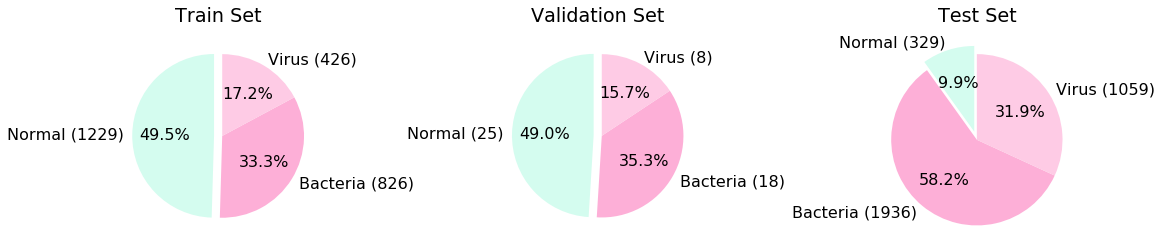

In [163]:
colors = ['#D4FCEF', '#FDAFD7', '#FECBE5']

test_size = 0.2
validation_size = 0.02

sampler = RandomUnderSampler(random_state = 0)
X_balanced, _ = sampler.fit_resample(dataset[['path']].values, dataset[['target']].values)

balanced_dataset = pd.DataFrame({'path': X_balanced[:, 0]})
balanced_dataset = balanced_dataset.sample(frac = 1, random_state = 0).reset_index(drop = True)
balanced_dataset = pd.merge(balanced_dataset, dataset, on = 'path')
rest_dataset = pd.DataFrame(
    {'path': list(set(X_balanced[:, 0].tolist()).symmetric_difference(dataset[['path']].values[:, 0].tolist()))})
rest_dataset = rest_dataset.sample(frac = 1, random_state = 0).reset_index(drop = True)
rest_dataset = pd.merge(rest_dataset, dataset, on = 'path')

X_train_validation, X_test, y_train_validation, _ = train_test_split(
    balanced_dataset.path.values, balanced_dataset.target.values,
    test_size = test_size, random_state = 0)
X_train, X_validation, _, _ = train_test_split(
    X_train_validation, y_train_validation,
    test_size = validation_size, random_state = 3)

train_dataset = pd.merge(pd.DataFrame({'path': X_train}), dataset, on = 'path')
validation_dataset = pd.merge(pd.DataFrame({'path': X_validation}), dataset, on = 'path')
test_dataset = pd.concat([pd.merge(pd.DataFrame({'path': X_test}), dataset, on = 'path'), rest_dataset])

fig = plt.figure(figsize = (17, 4))
ax1 = fig.add_subplot(131)
ax1.pie(sizes(train_dataset.sum()[1], train_dataset.sum()[2], train_dataset.sum()[3]),
        explode = (0.1, 0, 0), labels = labels(train_dataset.sum()[1], train_dataset.sum()[2], train_dataset.sum()[3]),
        autopct = '%1.1f%%', startangle = 90, colors = colors)
ax1.axis('equal')
ax1.title.set_text('Train Set')

ax3 = fig.add_subplot(132)
ax3.pie(sizes(validation_dataset.sum()[1], validation_dataset.sum()[2], validation_dataset.sum()[3]),
        explode = (0.1, 0, 0),
        labels = labels(validation_dataset.sum()[1], validation_dataset.sum()[2], validation_dataset.sum()[3]),
        autopct = '%1.1f%%', startangle = 90, colors = colors)
ax3.axis('equal')
ax3.title.set_text('Validation Set')

ax2 = fig.add_subplot(133)
ax2.pie(sizes(test_dataset.sum()[1], test_dataset.sum()[2], test_dataset.sum()[3]),
        explode = (0.1, 0, 0), labels = labels(test_dataset.sum()[1], test_dataset.sum()[2], test_dataset.sum()[3]),
        autopct = '%1.1f%%', startangle = 90, colors = colors)
ax2.axis('equal')
ax2.title.set_text('Test Set')

plt.subplots_adjust(wspace = 1)
plt.show()

In order to increase an amount of the train data we use image generators with horizontal flip augmentation

In [138]:
imageGenerator = ImageDataGenerator(rescale = 1. / 255, horizontal_flip = True)
testGenerator = ImageDataGenerator(rescale = 1. / 255)

batch_size = 4
x_col = 'path'
y_col = 'target'
classes = ['Normal', 'Pneumonia']
mode = 'grayscale'
target_size = (150, 150)

print('Train generator:')
train_generator = imageGenerator.flow_from_dataframe(train_dataset, x_col = x_col, y_col = y_col,
                                                     seed = 0, target_size = target_size, batch_size = batch_size,
                                                     class_mode = 'binary', color_mode = mode)

print('\nValidation generator:')
validation_generator = testGenerator.flow_from_dataframe(validation_dataset, x_col = x_col, y_col = y_col,
                                                         seed = 0, target_size = target_size, batch_size = batch_size,
                                                         class_mode = 'binary', color_mode = mode, shuffle = False)

print('\nTest generator:')
test_generator = testGenerator.flow_from_dataframe(test_dataset, x_col = x_col, y_col = y_col,
                                                   seed = 0, target_size = target_size, batch_size = 1,
                                                   class_mode = 'binary', color_mode = mode, shuffle = False)

Train generator:
Found 2481 validated image filenames belonging to 2 classes.

Validation generator:
Found 51 validated image filenames belonging to 2 classes.

Test generator:
Found 3324 validated image filenames belonging to 2 classes.


In [13]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = train_generator.image_shape))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.15))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.15))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.15))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.15))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.15))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.15))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 74, 74, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
___________________________

Define custom metrics

In [14]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


model_check_point = ModelCheckpoint(
    models_binary_dir + 'pneumonia-{val_loss:.2f}-{val_acc:.2f}-{val_precision:.2f}-{val_recall:.2f}.hdf5',
    save_best_only = True, verbose = 1, monitor = 'val_acc', mode = 'max')

Train neural network

In [15]:
optimizer = Adam()

model.compile(loss = 'binary_crossentropy', optimizer = optimizer,
              metrics = ['accuracy', recall, precision])

train_generator.reset()
validation_generator.reset()
history = model.fit_generator(epochs = 100, shuffle = True, validation_data = validation_generator,
                              steps_per_epoch = 100, generator = train_generator,
                              validation_steps = validation_dataset.shape[0] * batch_size,
                              verbose = 1, callbacks = [model_check_point])

Epoch 1/100
100/100 [==============================] - 26s 257ms/step - loss: 0.5888 - acc: 0.7050 - recall: 0.6925 - precision: 0.7167 - val_loss: 0.5527 - val_acc: 0.7228 - val_recall: 0.4528 - val_precision: 0.6242

Epoch 00001: val_acc improved from -inf to 0.72285, saving model to ./models/binary/pneumonia-0.55-0.72-0.62-0.45.hdf5
Epoch 2/100
100/100 [==============================] - 22s 225ms/step - loss: 0.5227 - acc: 0.7425 - recall: 0.7142 - precision: 0.7092 - val_loss: 0.6258 - val_acc: 0.7488 - val_recall: 0.4492 - val_precision: 0.5633

Epoch 00002: val_acc improved from 0.72285 to 0.74875, saving model to ./models/binary/pneumonia-0.63-0.75-0.56-0.45.hdf5
Epoch 3/100
100/100 [==============================] - 23s 232ms/step - loss: 0.3921 - acc: 0.8275 - recall: 0.8183 - precision: 0.8417 - val_loss: 0.5193 - val_acc: 0.8013 - val_recall: 0.6267 - val_precision: 0.7317

Epoch 00003: val_acc improved from 0.74875 to 0.80125, saving model to ./models/binary/pneumonia-0.52-


Epoch 00028: val_acc did not improve from 0.88250
Epoch 29/100
100/100 [==============================] - 26s 260ms/step - loss: 0.2482 - acc: 0.9075 - recall: 0.8525 - precision: 0.8667 - val_loss: 0.4745 - val_acc: 0.8800 - val_recall: 0.6517 - val_precision: 0.7850

Epoch 00029: val_acc did not improve from 0.88250
Epoch 30/100
100/100 [==============================] - 24s 240ms/step - loss: 0.3024 - acc: 0.8700 - recall: 0.7958 - precision: 0.8233 - val_loss: 0.4538 - val_acc: 0.8614 - val_recall: 0.6525 - val_precision: 0.7441

Epoch 00030: val_acc did not improve from 0.88250
Epoch 31/100
100/100 [==============================] - 26s 260ms/step - loss: 0.2434 - acc: 0.8925 - recall: 0.8033 - precision: 0.8117 - val_loss: 0.3998 - val_acc: 0.8462 - val_recall: 0.7225 - val_precision: 0.7383

Epoch 00031: val_acc did not improve from 0.88250
Epoch 32/100
100/100 [==============================] - 28s 285ms/step - loss: 0.2924 - acc: 0.9025 - recall: 0.8317 - precision: 0.8634 - 

100/100 [==============================] - 27s 271ms/step - loss: 0.2317 - acc: 0.9200 - recall: 0.8625 - precision: 0.8708 - val_loss: 0.2026 - val_acc: 0.9413 - val_recall: 0.7850 - val_precision: 0.7600

Epoch 00058: val_acc improved from 0.94000 to 0.94125, saving model to ./models/binary/pneumonia-0.20-0.94-0.76-0.78.hdf5
Epoch 59/100
100/100 [==============================] - 27s 266ms/step - loss: 0.2468 - acc: 0.9075 - recall: 0.8458 - precision: 0.8617 - val_loss: 0.3632 - val_acc: 0.8240 - val_recall: 0.8240 - val_precision: 0.7070

Epoch 00059: val_acc did not improve from 0.94125
Epoch 60/100
100/100 [==============================] - 27s 269ms/step - loss: 0.1927 - acc: 0.9225 - recall: 0.8658 - precision: 0.8967 - val_loss: 0.4292 - val_acc: 0.9038 - val_recall: 0.6942 - val_precision: 0.7850

Epoch 00060: val_acc did not improve from 0.94125
Epoch 61/100
100/100 [==============================] - 29s 295ms/step - loss: 0.1747 - acc: 0.9350 - recall: 0.8433 - precision: 0

100/100 [==============================] - 24s 238ms/step - loss: 0.2209 - acc: 0.8900 - recall: 0.8133 - precision: 0.8517 - val_loss: 0.3413 - val_acc: 0.9201 - val_recall: 0.7574 - val_precision: 0.7574

Epoch 00088: val_acc did not improve from 0.94250
Epoch 89/100
100/100 [==============================] - 24s 236ms/step - loss: 0.1361 - acc: 0.9525 - recall: 0.9217 - precision: 0.9150 - val_loss: 0.2812 - val_acc: 0.9012 - val_recall: 0.6883 - val_precision: 0.7800

Epoch 00089: val_acc did not improve from 0.94250
Epoch 90/100
100/100 [==============================] - 24s 235ms/step - loss: 0.1492 - acc: 0.9450 - recall: 0.8908 - precision: 0.9042 - val_loss: 0.2392 - val_acc: 0.8850 - val_recall: 0.7650 - val_precision: 0.7183

Epoch 00090: val_acc did not improve from 0.94250
Epoch 91/100
100/100 [==============================] - 23s 235ms/step - loss: 0.1954 - acc: 0.9200 - recall: 0.8400 - precision: 0.8617 - val_loss: 0.2385 - val_acc: 0.8812 - val_recall: 0.7533 - val_pr

Plot the dependencies of loss, accuracy, recall and precision on the training epoch number

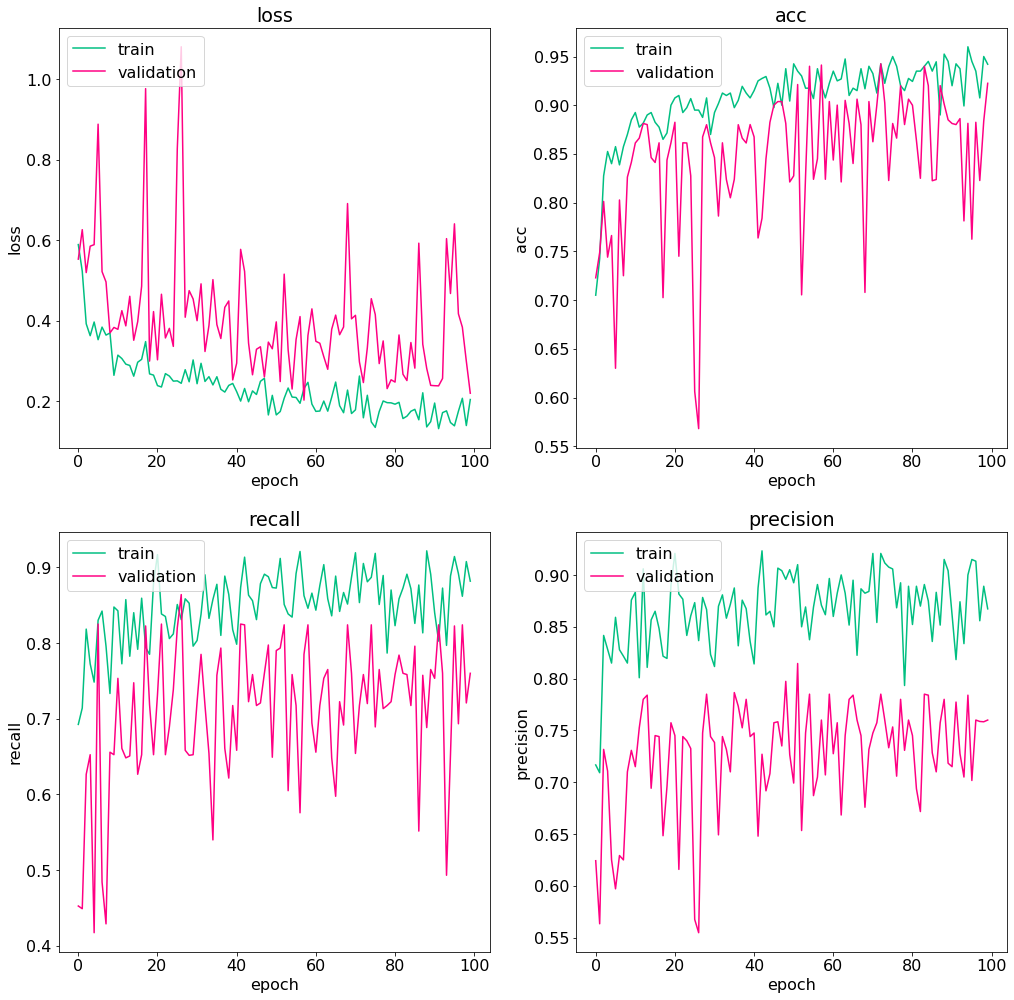

In [144]:
metrics = ['loss', 'acc', 'recall', 'precision']

fig = plt.figure(figsize = (17, 17))
for i, metric in enumerate(metrics):
    ax = plt.subplot(2, 2, i + 1)
    ax.set_facecolor('w')
    ax.grid(b = False)
    ax.plot(history.history[metric], color = '#00bf81')
    ax.plot(history.history['val_' + metric], color = '#ff0083')
    plt.title(metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')

plt.show()

In [17]:
binary_models = []
for model_path in glob.glob(models_binary_dir + 'pneumonia-*.hdf5'):
    name = os.path.basename(model_path)
    (prefix, sep, suffix) = name.rpartition('.')
    scores = list(map(lambda k: float(k), prefix.split('-')[1:]))
    binary_models.append([model_path] + scores)

binary_models = pd.DataFrame(binary_models, columns = ['path', 'loss', 'acc', 'precision', 'recall'])

# sorted_models = binary_models.sort_values(['acc', 'loss'], ascending = [False, True])
sorted_models = binary_models.sort_values(['acc', 'precision'], ascending = [False, False])

best_binary_model_path = sorted_models.path.iloc[0]
print('Best binary model:', best_binary_model_path)

Best binary model: ./models/binary/pneumonia-0.21-0.94-0.84-0.80.hdf5


In [18]:
best_binary_model = load_model(best_binary_model_path, custom_objects = {
    'recall': recall,
    'precision': precision
})

In [19]:
test_generator.reset()
test_pred = best_binary_model.predict_generator(test_generator, verbose = 1, steps = test_dataset.shape[0])

3324/3324 [==============================] - 30s 9ms/step


In [20]:
print(classification_report(test_generator.classes, np.rint(test_pred).astype(int).flatten(), target_names = classes))

              precision    recall  f1-score   support

      Normal       0.66      0.94      0.78       329
   Pneumonia       0.99      0.95      0.97      2995

    accuracy                           0.95      3324
   macro avg       0.83      0.94      0.87      3324
weighted avg       0.96      0.95      0.95      3324



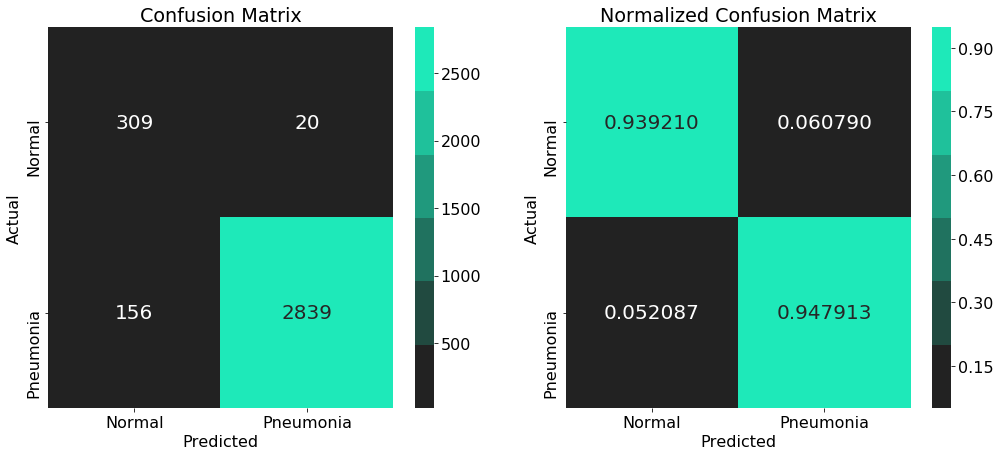

In [145]:
cm = confusion_matrix(y_true = test_generator.classes, y_pred = np.rint(test_pred).astype(int).flatten().tolist())
ncm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

fig = plt.figure(figsize = (17, 7))

ax = plt.subplot(1, 2, 1)
sns.heatmap(cm, annot = True, annot_kws = {"size": 20}, ax = ax, fmt = 'd',
            cmap = sns.dark_palette((30 / 256, 234 / 256, 186 / 256), input = "rgb"))

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

ax = plt.subplot(1, 2, 2)
sns.heatmap(ncm, annot = True, annot_kws = {"size": 20}, ax = ax, fmt = 'f',
            cmap = sns.dark_palette((30 / 256, 234 / 256, 186 / 256), input = "rgb"))

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Normalized Confusion Matrix')
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

plt.show()

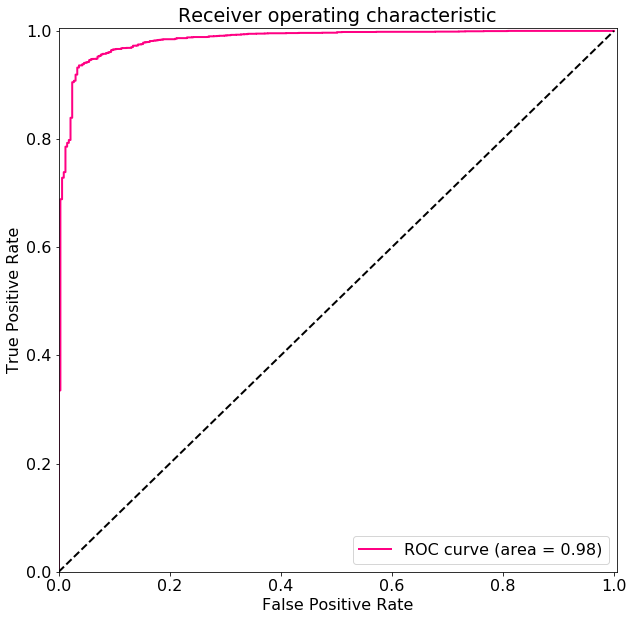

In [166]:
fpr, tpr, thresholds = roc_curve(test_generator.classes, test_pred)

fig = plt.figure(figsize=(10, 10))
lw = 2
plt.plot(fpr, tpr, color='#ff0083',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.005])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## 2. Normal vs Bacterial vs Viral Classification

In order to find multi-class classification model let us rebalance dataset again to have the same portions for normal, bacterial and viral classes 

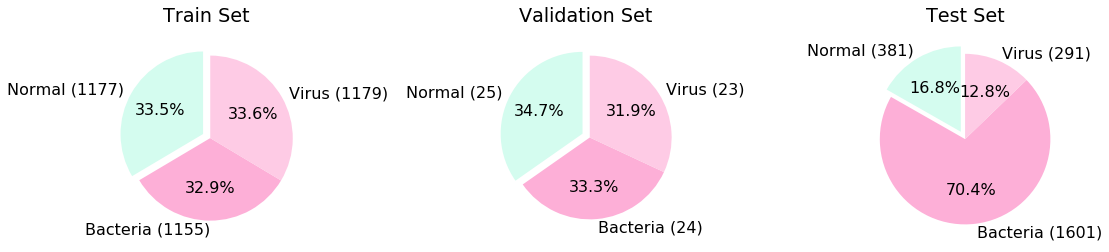

In [155]:
test_size = 0.2
validation_size = 0.02

multi_class_dataset = dataset.copy()
multi_class_dataset['target'] = multi_class_dataset.apply(
    lambda row: 'Normal' if row['normal'] == 1 else 'Bacterial' if row['bacteria'] == 1 else 'Viral', axis = 1)

sampler = RandomUnderSampler(random_state = 0)
X_balanced, _ = sampler.fit_resample(multi_class_dataset[['path']].values, multi_class_dataset[['target']].values)

balanced_multi_class_dataset = pd.DataFrame({'path': X_balanced[:, 0]})
balanced_multi_class_dataset = balanced_multi_class_dataset.sample(frac = 1, random_state = 0).reset_index(drop = True)
balanced_multi_class_dataset = pd.merge(balanced_multi_class_dataset, multi_class_dataset, on = 'path')

rest_multi_class_dataset = pd.DataFrame(
    {'path': list(
        set(X_balanced[:, 0].tolist()).symmetric_difference(multi_class_dataset[['path']].values[:, 0].tolist()))})
rest_multi_class_dataset = rest_multi_class_dataset.sample(frac = 1, random_state = 0).reset_index(drop = True)
rest_multi_class_dataset = pd.merge(rest_multi_class_dataset, multi_class_dataset, on = 'path')

X_train_validation, X_test, y_train_validation, _ = train_test_split(
    balanced_multi_class_dataset.path.values, balanced_multi_class_dataset.target.values,
    test_size = test_size, random_state = 3)

X_train, X_validation, _, _ = train_test_split(
    X_train_validation, y_train_validation,
    test_size = validation_size, random_state = 2)

train_multi_class_dataset = pd.merge(pd.DataFrame({'path': X_train}), multi_class_dataset, on = 'path')
validation_multi_class_dataset = pd.merge(pd.DataFrame({'path': X_validation}), multi_class_dataset, on = 'path')
test_multi_class_dataset = pd.concat(
    [pd.merge(pd.DataFrame({'path': X_test}), multi_class_dataset, on = 'path'), rest_multi_class_dataset])

fig = plt.figure(figsize = (17, 4))
ax1 = fig.add_subplot(131)
ax1.pie(
    sizes(train_multi_class_dataset.sum()[1], train_multi_class_dataset.sum()[2], train_multi_class_dataset.sum()[3]),
    explode = (0.1, 0, 0), labels = labels(train_multi_class_dataset.sum()[1], train_multi_class_dataset.sum()[2],
                                           train_multi_class_dataset.sum()[3]),
    autopct = '%1.1f%%', startangle = 90, colors = colors)
ax1.axis('equal')
ax1.title.set_text('Train Set')

ax3 = fig.add_subplot(132)
ax3.pie(sizes(validation_multi_class_dataset.sum()[1], validation_multi_class_dataset.sum()[2],
              validation_multi_class_dataset.sum()[3]),
        explode = (0.1, 0, 0),
        labels = labels(validation_multi_class_dataset.sum()[1], validation_multi_class_dataset.sum()[2],
                        validation_multi_class_dataset.sum()[3]),
        autopct = '%1.1f%%', startangle = 90, colors = colors)
ax3.axis('equal')
ax3.title.set_text('Validation Set')

ax2 = fig.add_subplot(133)
ax2.pie(sizes(test_multi_class_dataset.sum()[1], test_multi_class_dataset.sum()[2], test_multi_class_dataset.sum()[3]),
        explode = (0.1, 0, 0), labels = labels(test_multi_class_dataset.sum()[1], test_multi_class_dataset.sum()[2],
                                               test_multi_class_dataset.sum()[3]),
        autopct = '%1.1f%%', startangle = 90, colors = colors)
ax2.axis('equal')
ax2.title.set_text('Test Set')

plt.subplots_adjust(wspace = 1)
plt.show()

In [23]:
imageGenerator = ImageDataGenerator(rescale = 1. / 255, horizontal_flip = True)
testGenerator = ImageDataGenerator(rescale = 1. / 255)

batch_size = 4
x_col = 'path'
y_col = 'target'
multi_classes = ['Normal', 'Bacterial', 'Viral']
mode = 'grayscale'
target_size = (150, 150)

print('Train generator:')
train_multi_class_generator = imageGenerator.flow_from_dataframe(train_multi_class_dataset, x_col = x_col,
                                                                 y_col = y_col, classes = multi_classes,
                                                                 seed = 0, target_size = target_size,
                                                                 batch_size = batch_size,
                                                                 class_mode = 'categorical', color_mode = mode)

print('\nValidation generator:')
validation_multi_class_generator = testGenerator.flow_from_dataframe(validation_multi_class_dataset, x_col = x_col,
                                                                     y_col = y_col, classes = multi_classes,
                                                                     seed = 0, target_size = target_size,
                                                                     batch_size = batch_size,
                                                                     class_mode = 'categorical', color_mode = mode,
                                                                     shuffle = False)

print('\nTest generator:')
test_multi_class_generator = testGenerator.flow_from_dataframe(test_multi_class_dataset, x_col = x_col, y_col = y_col,
                                                               seed = 0, target_size = target_size, batch_size = 1,
                                                               class_mode = 'categorical', color_mode = mode,
                                                               shuffle = False, classes = multi_classes)

Train generator:
Found 3511 validated image filenames belonging to 3 classes.

Validation generator:
Found 72 validated image filenames belonging to 3 classes.

Test generator:
Found 2273 validated image filenames belonging to 3 classes.


We will keep network architecture the same but change the last layer to have 3 neurons only 

In [24]:
multi_class_model = Sequential()

multi_class_model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = train_generator.image_shape))
multi_class_model.add(MaxPooling2D((2, 2)))
multi_class_model.add(BatchNormalization())
multi_class_model.add(Dropout(rate = 0.15))

multi_class_model.add(Conv2D(64, (3, 3), activation = 'relu'))
multi_class_model.add(MaxPooling2D((2, 2)))
multi_class_model.add(BatchNormalization())
multi_class_model.add(Dropout(rate = 0.15))

multi_class_model.add(Conv2D(128, (3, 3), activation = 'relu'))
multi_class_model.add(MaxPooling2D((2, 2)))
multi_class_model.add(BatchNormalization())
multi_class_model.add(Dropout(rate = 0.15))

multi_class_model.add(Conv2D(128, (3, 3), activation = 'relu'))
multi_class_model.add(MaxPooling2D((2, 2)))
multi_class_model.add(BatchNormalization())
multi_class_model.add(Dropout(rate = 0.15))

multi_class_model.add(Conv2D(128, (3, 3), activation = 'relu'))
multi_class_model.add(MaxPooling2D((2, 2)))

multi_class_model.add(GlobalAveragePooling2D())
multi_class_model.add(Dense(64, activation = 'relu'))
multi_class_model.add(Dropout(0.15))

multi_class_model.add(Dense(128, activation = 'relu'))
multi_class_model.add(Dropout(0.15))
multi_class_model.add(Dense(len(multi_classes), activation = 'softmax'))

multi_class_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 74, 74, 32)        128       
_________________________________________________________________
dropout_7 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 36, 36, 64)        256       
__________

In [25]:
multi_class_model_check_point = ModelCheckpoint(
    models_categorical_dir + 'pneumonia-{val_loss:.2f}-{val_acc:.2f}-{val_precision:.2f}-{val_recall:.2f}.hdf5',
    save_best_only = True, verbose = 1, monitor = 'val_acc', mode = 'max')

In [26]:
multi_class_optimizer = Adam()

multi_class_model.compile(loss = 'categorical_crossentropy', optimizer = multi_class_optimizer,
                          metrics = ['accuracy', recall, precision])

train_multi_class_generator.reset()
validation_multi_class_generator.reset()
multi_class_history = multi_class_model.fit_generator(epochs = 100, shuffle = True, 
                                          validation_data = validation_multi_class_generator,
                                          steps_per_epoch = 100, 
                                          generator = train_multi_class_generator,
                                          validation_steps = validation_multi_class_dataset.shape[0] * batch_size,
                                          verbose = 1, callbacks = [multi_class_model_check_point])

Epoch 1/100
100/100 [==============================] - 28s 284ms/step - loss: 1.1038 - acc: 0.4375 - recall: 0.3325 - precision: 0.5108 - val_loss: 1.4406 - val_acc: 0.3194 - val_recall: 0.3194 - val_precision: 0.3194

Epoch 00001: val_acc improved from -inf to 0.31944, saving model to ./models/categorical/pneumonia-1.44-0.32-0.32-0.32.hdf5
Epoch 2/100
100/100 [==============================] - 26s 257ms/step - loss: 0.9737 - acc: 0.5500 - recall: 0.4025 - precision: 0.6025 - val_loss: 1.0172 - val_acc: 0.4861 - val_recall: 0.4306 - val_precision: 0.4861

Epoch 00002: val_acc improved from 0.31944 to 0.48611, saving model to ./models/categorical/pneumonia-1.02-0.49-0.49-0.43.hdf5
Epoch 3/100
100/100 [==============================] - 27s 268ms/step - loss: 0.9150 - acc: 0.5675 - recall: 0.4500 - precision: 0.5992 - val_loss: 0.9957 - val_acc: 0.4861 - val_recall: 0.4167 - val_precision: 0.5324

Epoch 00003: val_acc did not improve from 0.48611
Epoch 4/100
100/100 [=====================


Epoch 00029: val_acc did not improve from 0.76389
Epoch 30/100
100/100 [==============================] - 25s 254ms/step - loss: 0.6199 - acc: 0.7275 - recall: 0.6625 - precision: 0.7642 - val_loss: 0.8390 - val_acc: 0.6528 - val_recall: 0.5417 - val_precision: 0.7361

Epoch 00030: val_acc did not improve from 0.76389
Epoch 31/100
100/100 [==============================] - 26s 255ms/step - loss: 0.6626 - acc: 0.6975 - recall: 0.6225 - precision: 0.7583 - val_loss: 0.5397 - val_acc: 0.7778 - val_recall: 0.6389 - val_precision: 0.8241

Epoch 00031: val_acc improved from 0.76389 to 0.77778, saving model to ./models/categorical/pneumonia-0.54-0.78-0.82-0.64.hdf5
Epoch 32/100
100/100 [==============================] - 25s 254ms/step - loss: 0.6147 - acc: 0.7300 - recall: 0.6700 - precision: 0.7742 - val_loss: 0.6064 - val_acc: 0.7500 - val_recall: 0.6667 - val_precision: 0.8102

Epoch 00032: val_acc did not improve from 0.77778
Epoch 33/100
100/100 [==============================] - 25s 25

100/100 [==============================] - 30s 305ms/step - loss: 0.5714 - acc: 0.7650 - recall: 0.7300 - precision: 0.7808 - val_loss: 0.7088 - val_acc: 0.6944 - val_recall: 0.6111 - val_precision: 0.7454

Epoch 00059: val_acc did not improve from 0.84722
Epoch 60/100
100/100 [==============================] - 29s 291ms/step - loss: 0.5933 - acc: 0.7075 - recall: 0.6700 - precision: 0.7492 - val_loss: 0.4709 - val_acc: 0.8611 - val_recall: 0.7778 - val_precision: 0.8750

Epoch 00060: val_acc improved from 0.84722 to 0.86111, saving model to ./models/categorical/pneumonia-0.47-0.86-0.88-0.78.hdf5
Epoch 61/100
100/100 [==============================] - 28s 282ms/step - loss: 0.5887 - acc: 0.7575 - recall: 0.7150 - precision: 0.7775 - val_loss: 0.6417 - val_acc: 0.7222 - val_recall: 0.7083 - val_precision: 0.7546

Epoch 00061: val_acc did not improve from 0.86111
Epoch 62/100
100/100 [==============================] - 29s 286ms/step - loss: 0.5903 - acc: 0.7317 - recall: 0.7017 - precisi

100/100 [==============================] - 25s 248ms/step - loss: 0.5201 - acc: 0.7550 - recall: 0.7300 - precision: 0.7842 - val_loss: 0.5368 - val_acc: 0.7361 - val_recall: 0.7222 - val_precision: 0.7731

Epoch 00089: val_acc did not improve from 0.86111
Epoch 90/100
100/100 [==============================] - 26s 264ms/step - loss: 0.5237 - acc: 0.7600 - recall: 0.7300 - precision: 0.7867 - val_loss: 0.5199 - val_acc: 0.7639 - val_recall: 0.7500 - val_precision: 0.7778

Epoch 00090: val_acc did not improve from 0.86111
Epoch 91/100
100/100 [==============================] - 26s 264ms/step - loss: 0.5767 - acc: 0.7275 - recall: 0.6875 - precision: 0.7558 - val_loss: 0.4844 - val_acc: 0.7778 - val_recall: 0.7361 - val_precision: 0.8056

Epoch 00091: val_acc did not improve from 0.86111
Epoch 92/100
100/100 [==============================] - 28s 276ms/step - loss: 0.5998 - acc: 0.7425 - recall: 0.7125 - precision: 0.7708 - val_loss: 0.7598 - val_acc: 0.6667 - val_recall: 0.5556 - val_pr

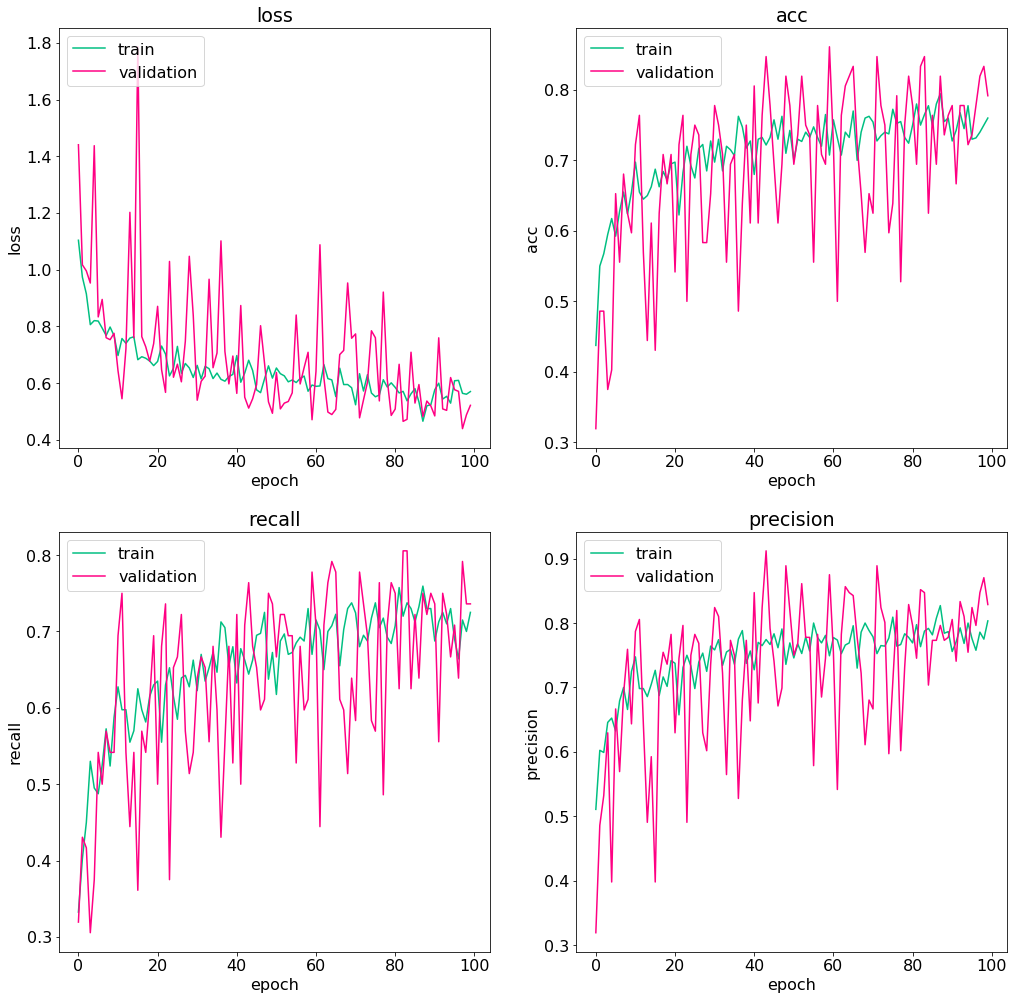

In [158]:
metrics = ['loss', 'acc', 'recall', 'precision']

fig = plt.figure(figsize = (17, 17))
for i, metric in enumerate(metrics):
    ax = plt.subplot(2, 2, i + 1)
    ax.set_facecolor('w')
    ax.grid(b = False)
    ax.plot(multi_class_history.history[metric], color = '#00bf81')
    ax.plot(multi_class_history.history['val_' + metric], color = '#ff0083')
    plt.title(metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')

plt.show()

In [28]:
categorical_models = []
for model_path in glob.glob(models_categorical_dir + 'pneumonia-*.hdf5'):
    name = os.path.basename(model_path)
    (prefix, sep, suffix) = name.rpartition('.')
    scores = list(map(lambda k: float(k), prefix.split('-')[1:]))
    categorical_models.append([model_path] + scores)

categorical_models = pd.DataFrame(categorical_models, columns = ['path', 'loss', 'acc', 'precision', 'recall'])

# sorted_models = categorical_models.sort_values(['acc', 'loss'], ascending = [False, True])
sorted_models = categorical_models.sort_values(['acc', 'precision'], ascending = [False, False])

best_categorical_model_path = sorted_models.path.iloc[0]
print('Best categorical model:', best_categorical_model_path)

Best categorical model: ./models/categorical/pneumonia-0.47-0.86-0.88-0.78.hdf5


In [29]:
best_categorical_model = load_model(best_categorical_model_path, custom_objects = {
    'recall': recall,
    'precision': precision
})

In [30]:
test_multi_class_generator.reset()
test_multi_class_pred = best_categorical_model.predict_generator(test_multi_class_generator, verbose = 1, steps = test_multi_class_dataset.shape[0])

2273/2273 [==============================] - 20s 9ms/step


In [42]:
class_labels = ['Bacterial', 'Normal', 'Viral']
print(classification_report(test_multi_class_generator.classes, np.argmax(test_multi_class_pred, axis = 1), target_names=class_labels))

              precision    recall  f1-score   support

   Bacterial       0.94      0.69      0.79      1601
      Normal       0.78      0.90      0.83       381
       Viral       0.30      0.68      0.41       291

    accuracy                           0.72      2273
   macro avg       0.67      0.75      0.68      2273
weighted avg       0.83      0.72      0.75      2273



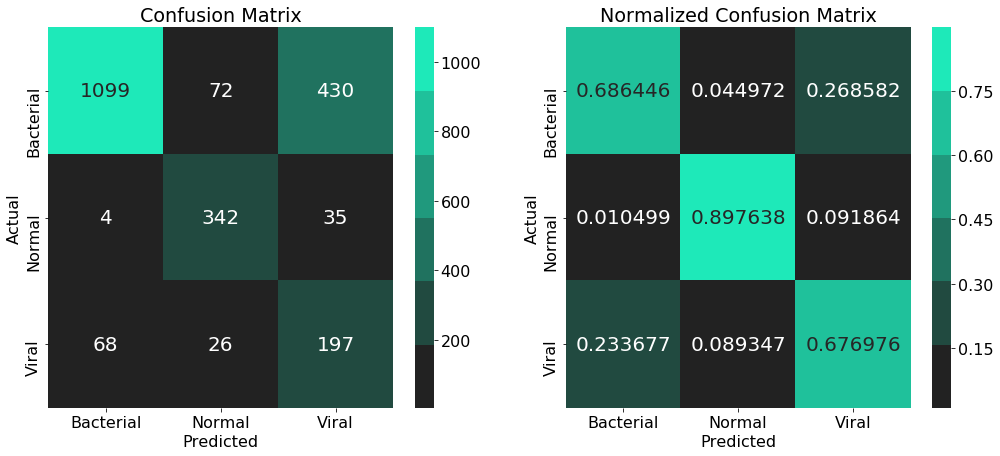

In [159]:
cm_multi_class = confusion_matrix(y_true = test_multi_class_generator.classes, y_pred = np.argmax(test_multi_class_pred, axis = 1))
ncm_multi_class = cm_multi_class.astype('float') / cm_multi_class.sum(axis = 1)[:, np.newaxis]

fig = plt.figure(figsize = (17, 7))

ax = plt.subplot(1, 2, 1)
sns.heatmap(cm_multi_class, annot = True, annot_kws = {"size": 20}, ax = ax, fmt = 'd',
            cmap = sns.dark_palette((30 / 256, 234 / 256, 186 / 256), input = "rgb"))

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

ax = plt.subplot(1, 2, 2)
sns.heatmap(ncm_multi_class, annot = True, annot_kws = {"size": 20}, ax = ax, fmt = 'f',
            cmap = sns.dark_palette((30 / 256, 234 / 256, 186 / 256), input = "rgb"))

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Normalized Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()

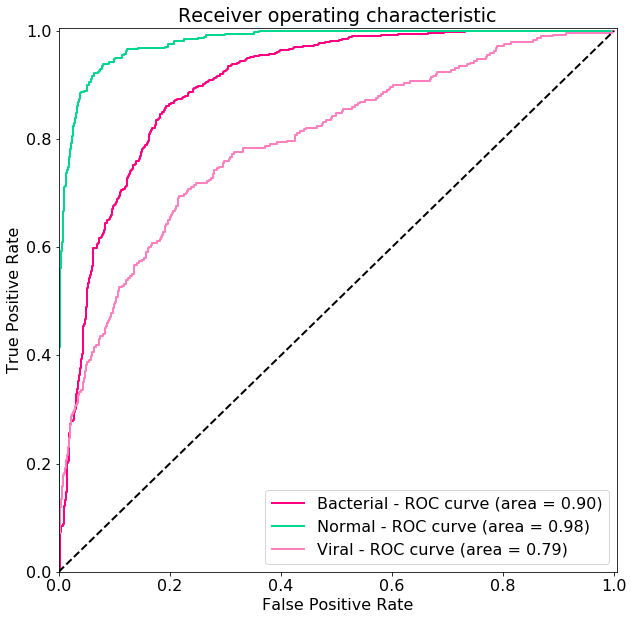

In [165]:
mc_pred = test_multi_class_pred
mc_true = label_binarize(test_multi_class_generator.classes, classes=[0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(multi_classes)):
    fpr[i], tpr[i], _ = roc_curve(mc_true[:, i], mc_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig = plt.figure(figsize=(10, 10))
lw = 2

colors = ['#ff0083', '#00d791', '#ff7ec0']

for i in range(len(multi_classes)):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             lw=lw, label=class_labels[i] + ' - ROC curve (area = %0.2f)' % roc_auc[i])

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.005])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Conclusion

We studied the two approaches of chest X-ray images classification. The former tries to find the fact of disease only which belongs to the binary classification problems class. In addidion, the latter tries to distinguish between the two forms of pneumonia: bacterial and viral. While the fact of disease is concluded with acceptable probabiliy, the specific form is the more difficult task for the considered network. An algorithm has more mistakes while deal with viral form. 